# Part 1: Analyze the network

The questions in this part are based on Lecture 5.

* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   - It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   - I would like you to include concepts like centrality and assortativity in your analysis.
   - Use a network backbone in your analysis.
   - In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   - **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.

# Part 2: Genres and communities and plotting 

## 2.1 Write about genres and modularity

**Modularity** basically measures how well a network is divided into communities compared to what we’d expect if the connections were random.
In our case, we treat **genres** as communities, so we’re checking whether artists that share the same genre are more connected to each other than they would be by chance.

The formula from the book (Eq. 9.12) is:

$$
M = \sum_{c=1}^{n_c} \left[\frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2\right]
$$

* $L$ is the total number of edges in the network.
* $L_c$ is the number of edges *inside* community $c$.
* $k_c$ is the sum of the degrees of all nodes in that community.

The first term $\frac{L_c}{L}$ tells us how many of the network’s links actually stay inside the community,
while the second term $\left(\frac{k_c}{2L}\right)^2$ represents how many we would expect if links were placed at random.
So, if a community has more internal connections than expected, it contributes positively to the modularity.

A modularity value close to **1** would mean there are strong, well-separated communities,
while values around **0** suggest that the partition (in this case, by genre) doesn’t really capture the network’s structure.

From the output below, we can see there are 314 artists in total, and each artist is part of about 4 genres on average. This means many artists play different kinds of music. Even if there are 334 genres in total, most artists belong to just a few popular ones. From the chart below, we can see that *alternative rock*, *hard rock*, and *pop rock* are the most common, while the other genres have a lot fewer artists.

Number of nodes with genres: 314
Average number of genres per node: 4.06
Total number of distinct genres: 334


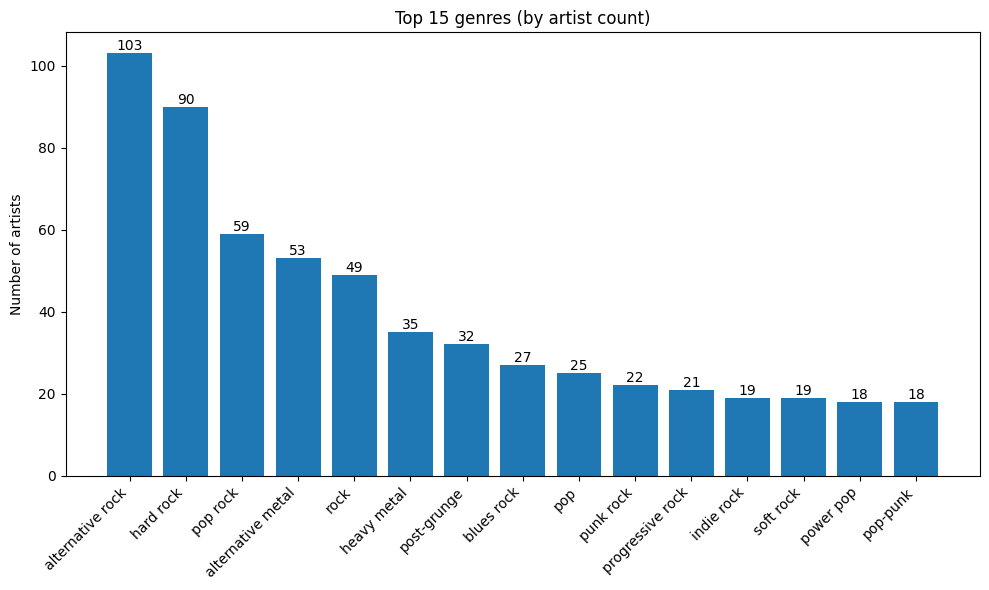

In [7]:
# === Load precomputed genres from GitHub (no parsing), report stats, and plot top-15 ===
import io
import json
import requests
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

BASE_URL = "https://raw.githubusercontent.com/lorenzocazzador/socialgraphs-data/refs/heads/main/rock_performers_wikitext"

def load_text_from_github(path: str) -> str:
    url = f"{BASE_URL}/{path}"
    r = requests.get(url)
    r.raise_for_status()
    return r.text

# ---------------- Load precomputed mapping: artist -> genres ----------------
artist_genres_text = load_text_from_github("artist_genres.json")
artist_to_genres: dict[str, list[str]] = json.loads(artist_genres_text)

# ---------------- Report stats ----------------
num_with_genres = len(artist_to_genres)
avg_genres_per_node = (
    sum(len(v) for v in artist_to_genres.values()) / num_with_genres if num_with_genres else 0.0
)
distinct_genres = sorted({g for glist in artist_to_genres.values() for g in glist})

print(f"Number of nodes with genres: {num_with_genres}")
print(f"Average number of genres per node: {avg_genres_per_node:.2f}")
print(f"Total number of distinct genres: {len(distinct_genres)}")

# ---------------- Top-15 genre histogram ----------------
genre_counts = Counter(g for glist in artist_to_genres.values() for g in glist)
top15 = genre_counts.most_common(15)

labels = [g for g, _ in top15]
counts = [c for _, c in top15]

plt.figure(figsize=(10, 6))
ax = plt.gca()
bars = ax.bar(range(len(labels)), counts)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Number of artists")
ax.set_title("Top 15 genres (by artist count)")
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, str(counts[i]),
            ha="center", va="bottom")
plt.tight_layout()
plt.show()

## 2.2 Detect the communities, discuss the value of modularity in comparison to the genres.

We ran Louvain on the artist network and it found 8 communities. The modularity is 0.336, which is a moderate value, not super high, but still showing that there’s some real structure in the network. It means that artists tend to be more connected inside their own communities than with artists from other groups, but the separation isn’t perfect.

When we use genres as communities (like the first genre of each artist), the modularity is much lower (around ~0.10). So the structure-based communities are more meaningful than the genre-based ones. This makes sense because many artists belong to several genres, so using just one genre mixes things and breaks the clusters. Louvain, instead, groups artists based on how they actually connect in the network.


In [25]:
# === Community detection and visualization (data loaded from GitHub) ===
import json
import io
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps
from pathlib import Path
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
from infomap import Infomap
from matplotlib.patches import Patch
from fa2 import ForceAtlas2

# -------------------- GitHub base path --------------------
BASE_URL = "https://raw.githubusercontent.com/lorenzocazzador/socialgraphs-data/main/rock_performers_wikitext"

def load_csv_from_github(filename: str) -> pd.DataFrame:
    """Load a CSV file directly from GitHub raw URL."""
    url = f"{BASE_URL}/{filename}"
    r = requests.get(url)
    r.raise_for_status()
    return pd.read_csv(io.StringIO(r.text))

def load_json_from_github(filename: str) -> dict:
    """Load a JSON file directly from GitHub raw URL."""
    url = f"{BASE_URL}/{filename}"
    r = requests.get(url)
    r.raise_for_status()
    return json.loads(r.text)

# -------------------- Load data --------------------
print("🔹 Loading data from GitHub...")
nodes_df = load_csv_from_github("rock_performers_nodes.csv")
edges_df = load_csv_from_github("rock_performers_edges.csv")
artist_to_genres = load_json_from_github("artist_genres.json")

# -------------------- Build the graph --------------------
G_dir = nx.DiGraph()
for _, row in nodes_df.iterrows():
    attrs = row.to_dict()
    title = attrs.pop("title")
    G_dir.add_node(title, **attrs)

for _, row in edges_df.iterrows():
    G_dir.add_edge(row["source"], row["target"])

# Undirected version for community detection
G = G_dir.to_undirected()

# -------------------- Restrict to genre-known nodes --------------------
genre_nodes = [n for n in G.nodes if n in artist_to_genres and artist_to_genres[n]]
Gg = G.subgraph(genre_nodes).copy()
print(f"🎵 Genre-known subgraph: {Gg.number_of_nodes()} nodes, {Gg.number_of_edges()} edges")

# -------------------- Louvain communities --------------------
louvain_communities_list = louvain_communities(Gg, seed=42)
M_louvain = modularity(Gg, louvain_communities_list)
print(f"🧩 Louvain modularity: {M_louvain:.4f}")
print(f"🔸 Found {len(louvain_communities_list)} communities")

# -------------------- Compare with genre partition modularity --------------------
genre_part = {}
for n in Gg.nodes:
    g_list = artist_to_genres.get(n, [])
    if g_list:
        genre_part.setdefault(g_list[0], set()).add(n)
M_genre_first = modularity(Gg, list(genre_part.values()))
print(f"🎶 Genre (first-genre) modularity: {M_genre_first:.4f}")


🔹 Loading data from GitHub...
🎵 Genre-known subgraph: 314 nodes, 3205 edges
🧩 Louvain modularity: 0.3360
🔸 Found 8 communities
🎶 Genre (first-genre) modularity: 0.0967


## 2.3 Calculate the matrix $D$ and discuss your findings.

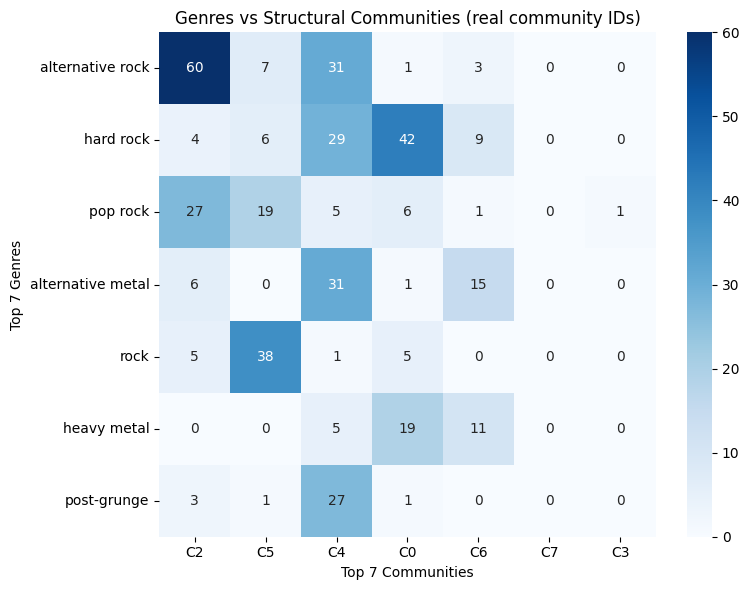

In [ ]:
# === Compare communities vs genres (short & clean) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Requires: Gg (graph), louvain_communities_list (list[set]), artist_to_genres (dict[str, list[str]])

# --- Top 7 genres & communities ---
top_genres = [g for g, _ in Counter(g for gl in artist_to_genres.values() for g in gl).most_common(7)]
comm_sizes = [len(c) for c in louvain_communities_list]
top_c_idx = np.argsort(comm_sizes)[::-1][:7]

# Fast lookups
genre_idx = {g: i for i, g in enumerate(top_genres)}
comm_col = {cid: j for j, cid in enumerate(top_c_idx)}
node2comm = {n: cid for cid, members in enumerate(louvain_communities_list) for n in members}

# --- Confusion matrix D (G × C) ---
D = np.zeros((len(top_genres), len(top_c_idx)), dtype=int)
for n in Gg.nodes:
    cid = node2comm.get(n)
    if cid not in comm_col:
        continue
    j = comm_col[cid]
    for g in artist_to_genres.get(n, []):
        i = genre_idx.get(g)
        if i is not None:
            D[i, j] += 1

# --- Greedy row reorder to look more diagonal ---
# remaining = set(range(D.shape[0]))
# row_order = []
# for j in range(D.shape[1]):
#     if not remaining: break
#     r = max(remaining, key=lambda i: D[i, j])
#     row_order.append(r); remaining.remove(r)
# row_order += sorted(remaining)

# --- Plot ---
D_df = pd.DataFrame(D, index=top_genres, columns=[f"C{j+1}" for j in range(D.shape[1])])
# D_df = D_df.iloc[row_order]

plt.figure(figsize=(8, 6))
sns.heatmap(D_df, annot=True, fmt="d", cmap="Blues")
plt.title("Genres vs Structural Communities (rows permuted)")
plt.xlabel("Top 7 Communities"); plt.ylabel("Top 7 Genres")
plt.tight_layout(); plt.show()

The matrix shows how the top 7 music genres are spread across the 7 biggest Louvain communities. Each number tells how many artists belong to both a certain genre and a certain community.

From the matrix, we can see that some genres like alternative rock, hard rock, and alternative metal have a lot of artists in just one or two communities. This means that the Louvain communities match quite well with these genres. For example, most alternative rock artists are in community C1, while hard rock artists are mostly in C4.

Other genres like pop rock and post-grunge are more spread out, which means those artists are mixed across different communities. This shows that these genres are less tightly connected and overlap more with others.

Overall, the matrix shows that there is a clear but not perfect connection between the genres and the structural communities. The network structure groups artists in a way that often follows their musical style, but not always exactly.


## 2.4 Plot the communities and comment on your results

100%|██████████| 500/500 [00:01<00:00, 252.81it/s]


BarnesHut Approximation  took  0.79  seconds
Repulsion forces  took  0.93  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


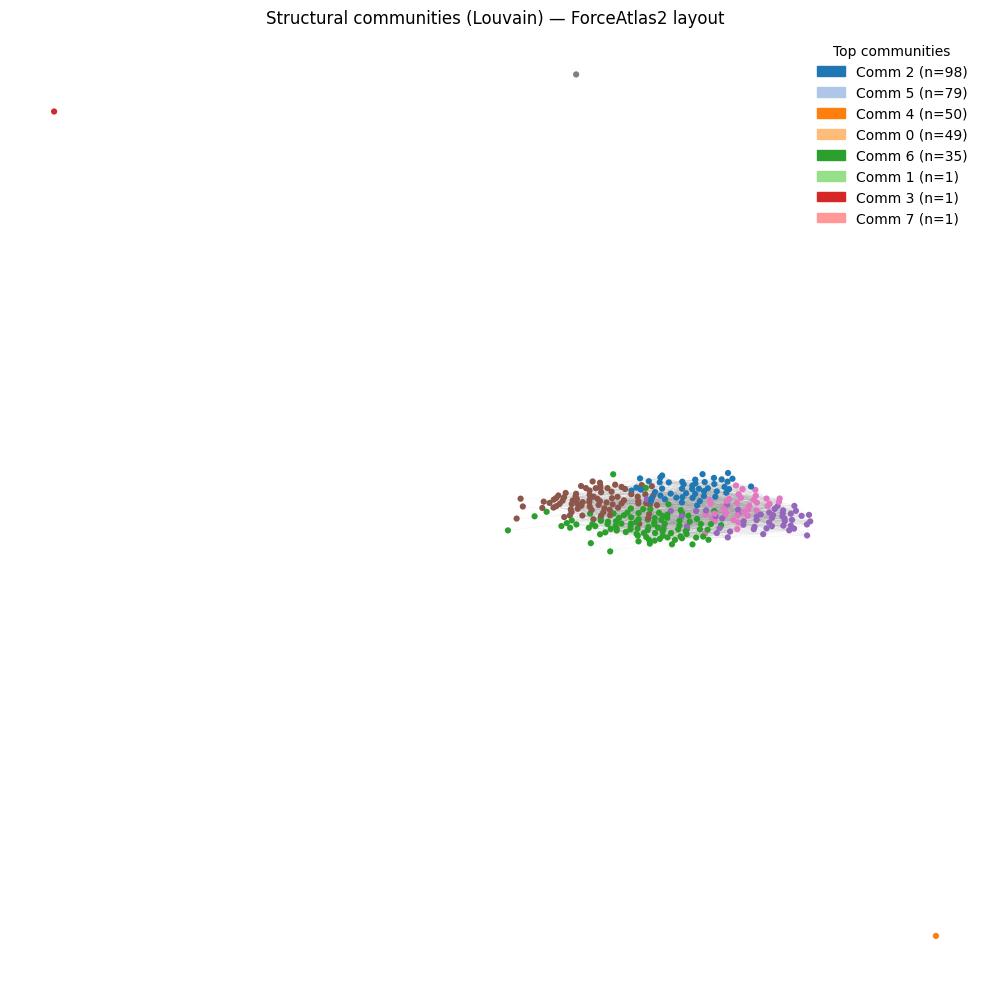

🕸️ Backbone keeps 321 edges (~top 10%)


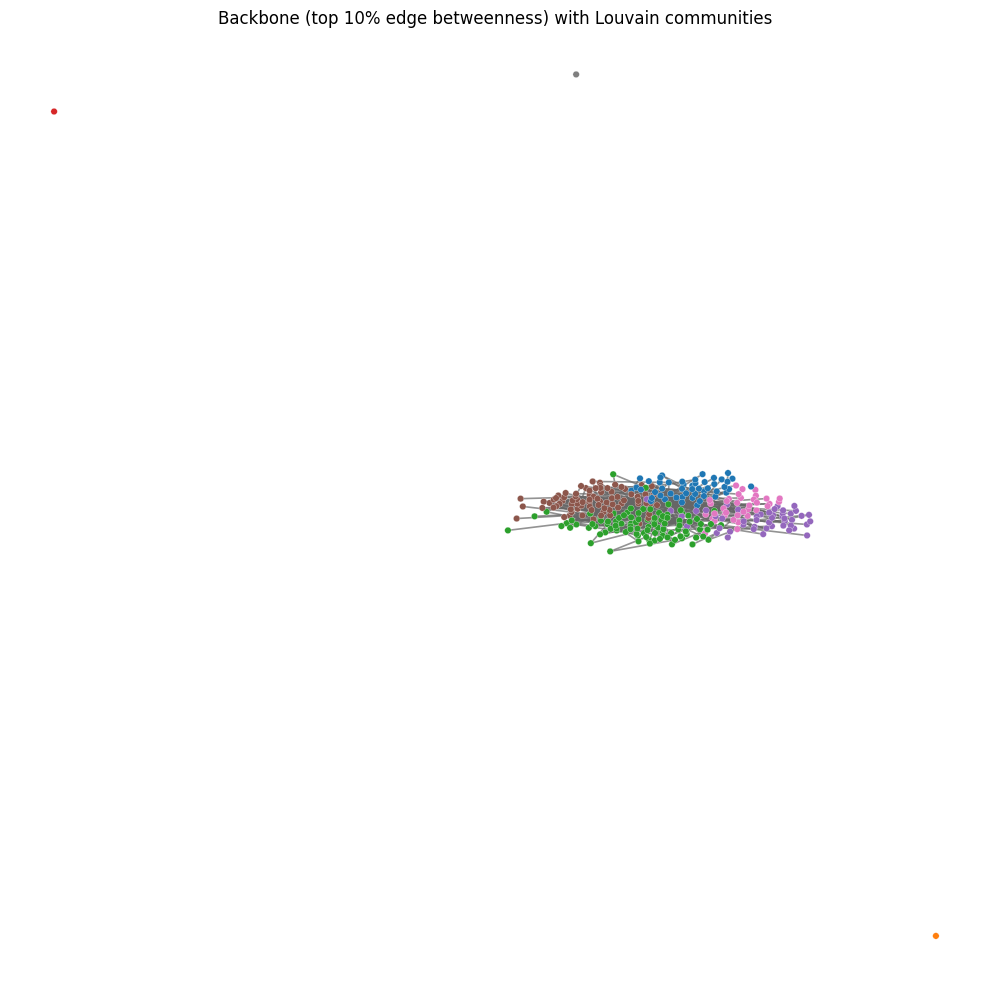

After removing singletons: 311 nodes, 3205 edges


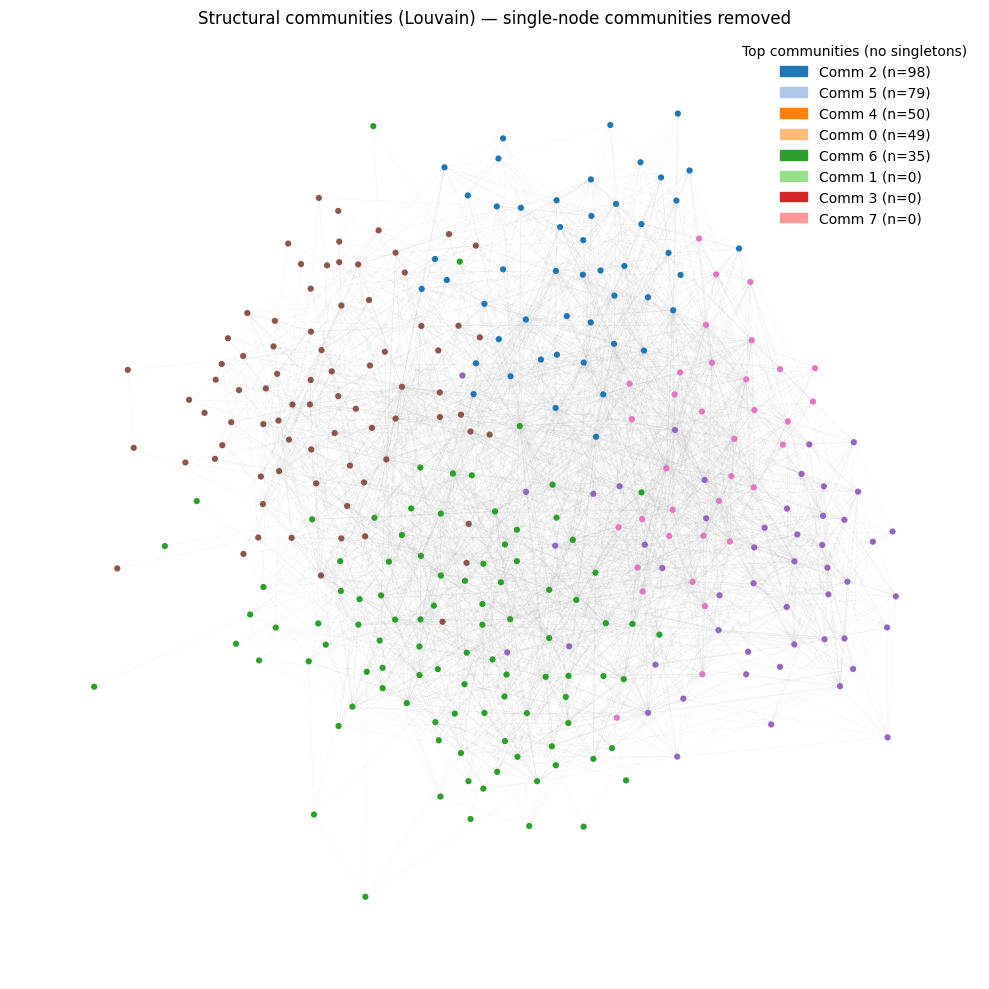

Backbone (no singletons) keeps 321 edges (~top 10%)


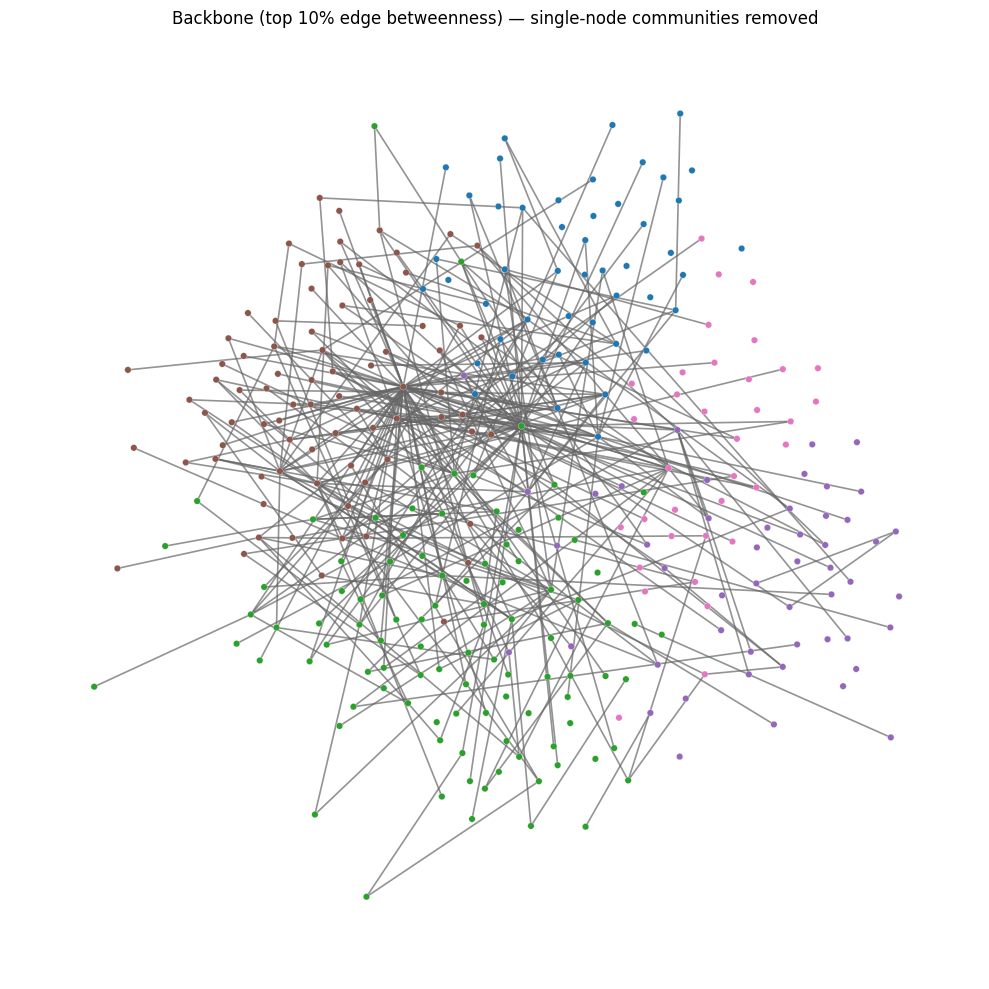

In [30]:
# Node -> community ID map
comm_list = [set(c) for c in louvain_communities_list]
comm_sizes = [len(c) for c in comm_list]
node2comm = {n: cid for cid, members in enumerate(comm_list) for n in members}

# -------------------- ForceAtlas2 layout --------------------
# Patch for NetworkX 3.x
if not hasattr(nx, 'to_scipy_sparse_matrix'):
    nx.to_scipy_sparse_matrix = nx.to_scipy_sparse_array

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0
)
pos = forceatlas2.forceatlas2_networkx_layout(Gg, iterations=500)

# -------------------- Color top-K communities --------------------
K = 10
top_idx = np.argsort(comm_sizes)[::-1][:K]
top_cids = set(int(i) for i in top_idx)
cmap = colormaps.get_cmap("tab20")
node_colors = [
    cmap(list(top_cids).index(node2comm[n]) / K) if node2comm[n] in top_cids
    else (0.85, 0.85, 0.85, 0.8)
    for n in Gg.nodes
]

# -------------------- Plot full graph --------------------
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(Gg, pos, width=0.3, alpha=0.15, edge_color="#999999")
nx.draw_networkx_nodes(Gg, pos, node_size=20, node_color=node_colors, linewidths=0)
sorted_top = sorted([(cid, comm_sizes[cid]) for cid in top_cids], key=lambda x: x[1], reverse=True)
plt.legend(
    handles=[Patch(color=cmap(i), label=f"Comm {cid} (n={size})") for i, (cid, size) in enumerate(sorted_top)],
    title="Top communities", loc="upper right", frameon=False
)
plt.axis("off")
plt.title("Structural communities (Louvain) — ForceAtlas2 layout")
plt.tight_layout()
plt.show()

# -------------------- Simple backbone (top 10% edge betweenness) --------------------
p = 0.10
eb = nx.edge_betweenness_centrality(Gg)
thr = np.quantile(list(eb.values()), 1 - p)
backbone_edges = [e for e, val in eb.items() if val >= thr]

Bb = nx.Graph()
Bb.add_nodes_from(Gg.nodes(data=True))
Bb.add_edges_from(backbone_edges)
print(f"🕸️ Backbone keeps {Bb.number_of_edges()} edges (~top {int(p*100)}%)")

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(Bb, pos, width=1.2, alpha=0.7, edge_color="#666666")
nx.draw_networkx_nodes(Bb, pos, node_size=22, node_color=node_colors, linewidths=0.2, edgecolors="white")
plt.axis("off")
plt.title("Backbone (top 10% edge betweenness) with Louvain communities")
plt.tight_layout()
plt.show()

# === Remove single-node communities and plot again ===

# 1) Find singleton community IDs and drop their nodes
singleton_cids = {cid for cid, sz in enumerate(comm_sizes) if sz == 1}
nodes_to_drop = [n for n, cid in node2comm.items() if cid in singleton_cids]

Gg_no_single = Gg.copy()
Gg_no_single.remove_nodes_from(nodes_to_drop)
print(f"After removing singletons: {Gg_no_single.number_of_nodes()} nodes, {Gg_no_single.number_of_edges()} edges")

# Reuse existing ForceAtlas2 positions for remaining nodes
pos2 = {n: pos[n] for n in Gg_no_single.nodes}

# 2) Recompute sizes restricted to remaining nodes (same Louvain labels)
comm_sizes2 = [len(set_c & set(Gg_no_single.nodes)) for set_c in comm_list]

# Color only top-K among the remaining communities
top_idx2 = np.argsort(comm_sizes2)[::-1][:K]
top_cids2 = set(int(i) for i in top_idx2)

node_colors2 = [
    cmap(list(top_cids2).index(node2comm[n]) / K) if node2comm[n] in top_cids2
    else (0.85, 0.85, 0.85, 0.8)
    for n in Gg_no_single.nodes
]

# 3) Plot graph without singleton communities
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(Gg_no_single, pos2, width=0.3, alpha=0.15, edge_color="#999999")
nx.draw_networkx_nodes(Gg_no_single, pos2, node_size=20, node_color=node_colors2, linewidths=0)

sorted_top2 = sorted([(cid, comm_sizes2[cid]) for cid in top_cids2], key=lambda x: x[1], reverse=True)
plt.legend(
    handles=[Patch(color=cmap(i), label=f"Comm {cid} (n={size})") for i, (cid, size) in enumerate(sorted_top2)],
    title="Top communities (no singletons)", loc="upper right", frameon=False
)
plt.axis("off")
plt.title("Structural communities (Louvain) — single-node communities removed")
plt.tight_layout()
plt.show()

# 4) Backbone again on the filtered graph
p = 0.10
eb2 = nx.edge_betweenness_centrality(Gg_no_single)
thr2 = np.quantile(list(eb2.values()), 1 - p)
backbone_edges2 = [e for e, val in eb2.items() if val >= thr2]

Bb2 = nx.Graph()
Bb2.add_nodes_from(Gg_no_single.nodes(data=True))
Bb2.add_edges_from(backbone_edges2)
print(f"Backbone (no singletons) keeps {Bb2.number_of_edges()} edges (~top {int(p*100)}%)")

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(Bb2, pos2, width=1.2, alpha=0.7, edge_color="#666666")
nx.draw_networkx_nodes(Bb2, pos2, node_size=22, node_color=node_colors2, linewidths=0.2, edgecolors="white")
plt.axis("off")
plt.title("Backbone (top 10% edge betweenness) — single-node communities removed")
plt.tight_layout()
plt.show()


The first two graphs show the full network of artists colored by their Louvain communities. Most of the artists are grouped together in the center, while a few single points are far away. These far points are single-node communities that do not really connect to others.

After removing those single-node communities, the third graph looks much clearer. Now there are five main groups that stand out, each shown in a different color. These groups represent artists that are more strongly connected to each other.

The last graph shows the backbone, where only the strongest 10 percent of the connections are kept. The network is more sparse here, but we can still see how some communities remain well connected in the middle, while others are more on the sides. This helps to focus on the most important links between the biggest artist groups.


# Part 3: TF-IDF to understand genres and communities 

## 3.1 Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

TF-IDF is a way to find which words are the most important in a group of texts. TF means term frequency and tells how often a word appears in a text. IDF means inverse document frequency and gives more value to words that appear in fewer texts. When we multiply them, we get a score that shows which words are special for each text.

In this project TF-IDF helps to find which words best describe each genre or community. For example, if a word appears a lot in artists from one genre but not in others, it will get a high TF-IDF score. This makes it easier to understand what makes each group unique and what kind of topics or styles are most common in their songs or descriptions.


## 3.2 Calculate and visualize TF-IDF for the genres and communities.

### 3.2.1 TF-IDF for the genres

Loaded 15 TF files from GitHub.
Top 15 genres: ['alternative rock', 'rock', 'hard rock', 'heavy metal', 'alternative metal', 'pop rock', 'progressive rock', 'pop', 'punk rock', 'blues rock', 'pop-punk', 'post-grunge', 'indie rock', 'soft rock', 'power pop']


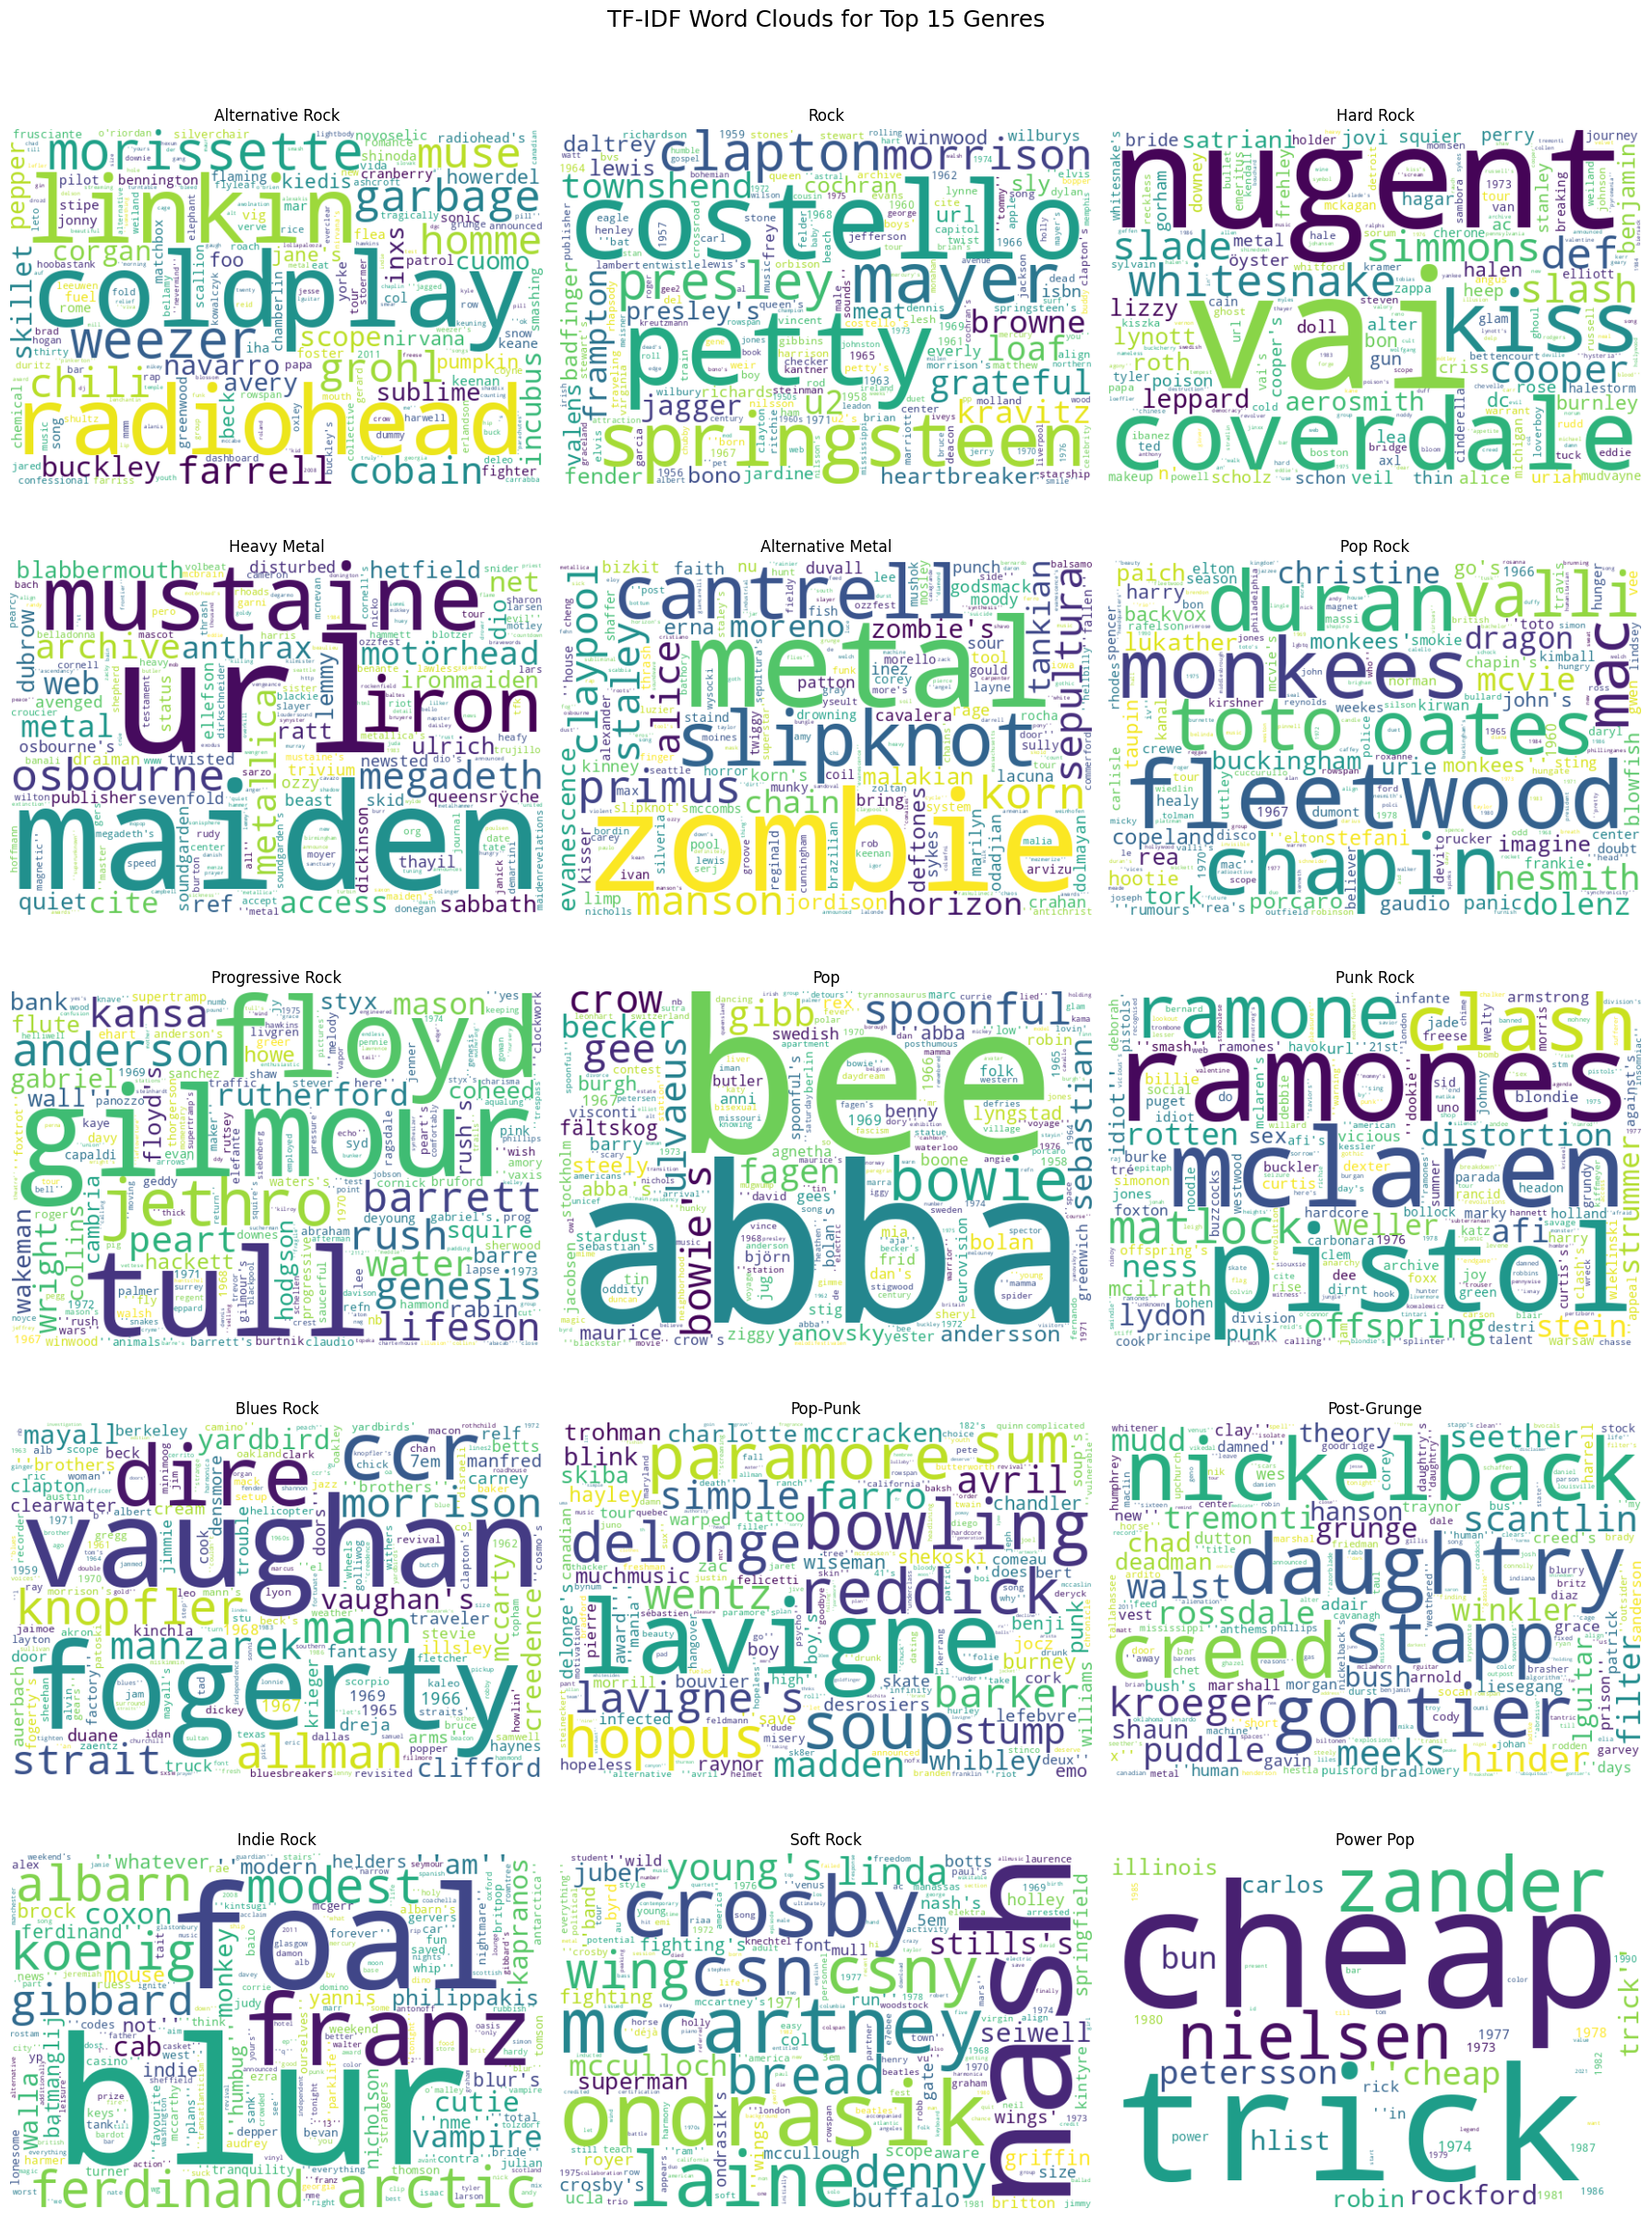

In [31]:
# TF–IDF wordclouds for the top-15 genres (load TF files from GitHub and show in one grid)

import math
import requests
from collections import Counter, defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# -------- Load TF lists from GitHub --------
OWNER   = "lorenzocazzador"
REPO    = "socialgraphs-data"
SUBPATH = "rock_performers_wikitext/tf_lists"

api_url = f"https://api.github.com/repos/{OWNER}/{REPO}/contents/{SUBPATH}"
resp = requests.get(api_url, timeout=30)
resp.raise_for_status()
entries = resp.json()

genre_tf: dict[str, Counter] = {}
for e in entries:
    name = e.get("name", "")
    if not name.startswith("tf_") or not name.endswith(".txt"):
        continue
    genre = name.removeprefix("tf_").removesuffix(".txt").replace("_", " ")
    raw_url = e.get("download_url")
    if not raw_url:
        continue

    r = requests.get(raw_url, timeout=30)
    r.raise_for_status()

    c = Counter()
    for line in r.text.splitlines():
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        w, cnt = parts
        try:
            c[w] = int(cnt)
        except ValueError:
            pass
    if c:
        genre_tf[genre] = c

# Pick top-15 genres by total token count
top_genres = sorted(genre_tf.keys(),
                    key=lambda g: sum(genre_tf[g].values()),
                    reverse=True)[:15]

print(f"Loaded {len(genre_tf)} TF files from GitHub.")
print("Top 15 genres:", top_genres)

# -------- Build DF and IDF --------
N = len(top_genres)
df = defaultdict(int)
for g in top_genres:
    for w in genre_tf[g].keys():
        df[w] += 1
idf = {w: math.log(N / df[w]) for w in df}

# -------- Compute TF-IDF and build wordclouds --------
wordclouds = []
titles = []

for g in top_genres:
    tf = genre_tf[g]
    tfidf = {w: tf[w] * idf.get(w, 0.0) for w in tf}
    if not tfidf:
        continue

    # Commented out to reduce output
    # top10 = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:10]
    # print(f"\n=== {g} — top 10 TF-IDF words ===")
    # for w, score in top10:
    #     print(f"{w:20s} {score:.3f}")

    maxv = max(tfidf.values())
    scaled = {w: v / maxv for w, v in tfidf.items()} if maxv > 0 else tfidf

    wc = WordCloud(
        width=600,
        height=400,
        background_color="white",
        max_words=200,
        colormap="viridis",
        collocations=False,
        stopwords=set(),
    ).generate_from_frequencies(scaled)

    wordclouds.append(wc)
    titles.append(g.title())

# -------- Plot all wordclouds in one grid (3 columns) --------
cols = 3
rows = math.ceil(len(wordclouds) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))

for i, ax in enumerate(axes.flat):
    if i < len(wordclouds):
        ax.imshow(wordclouds[i], interpolation="bilinear")
        ax.axis("off")
        ax.set_title(titles[i])
    else:
        ax.axis("off")

plt.suptitle("TF-IDF Word Clouds for Top 15 Genres", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


The TF-IDF results show the most important artists for each genre. A word gets a high value when it appears often in one genre but not in others. This helps to see what makes each genre special.

From the wordclouds, it is easy to see clear differences between genres. For example, alternative rock is full of modern bands, while heavy metal and hard rock include names linked to louder and more aggressive styles. Pop and soft rock have smoother artists, and punk rock shows more rebellious ones.

Each wordcloud has its own look and focus, meaning TF-IDF captures well the essence of every genre. There is very little overlap between them, so the method works well to highlight what makes each musical community unique.

### 3.2.2 TF-IDF for the communities

Using all 8 communities


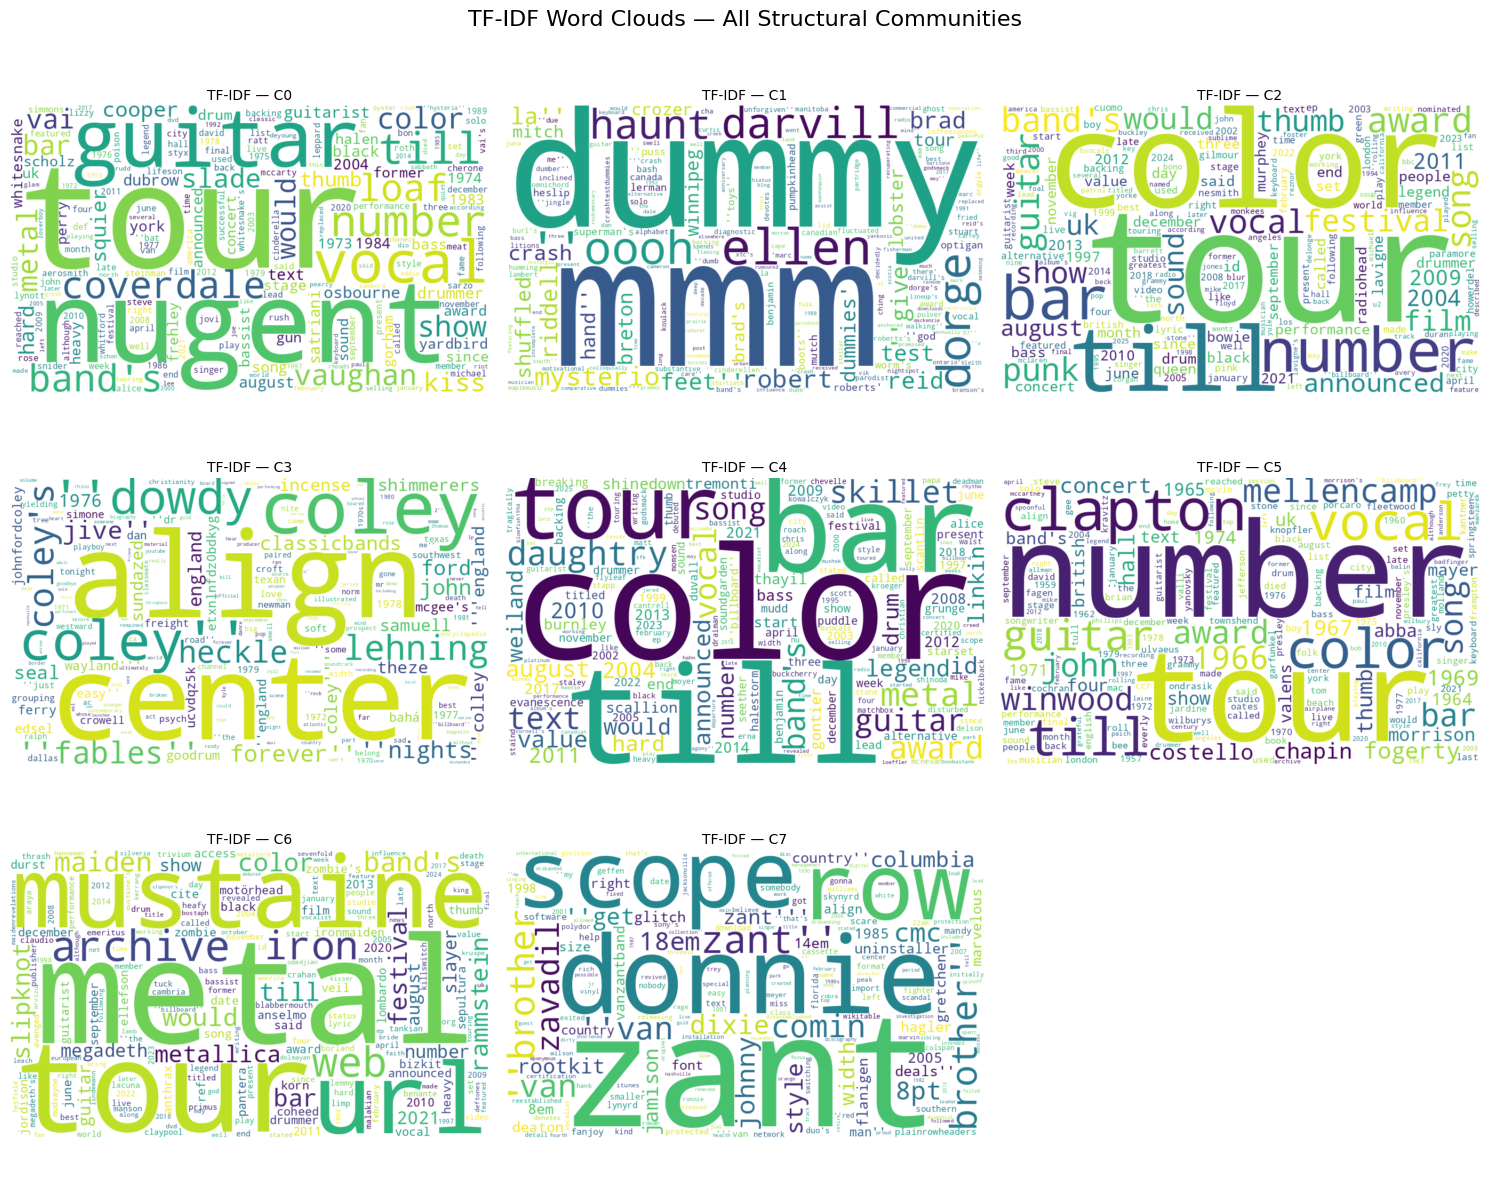

In [32]:
# === Community TF-IDF wordclouds (All structural communities) ===
# Loads pre-cleaned artist texts directly from GitHub, builds one document per community,
# computes TF-IDF across all communities, and plots all wordclouds in a single 3-column grid.

import math
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud

# ---------------------------------------------------------------------
# Prereqs assumed already in memory:
# - Gg (undirected subgraph)
# - louvain_communities_list (list[set] of artist titles)
# ---------------------------------------------------------------------

RAW_BASE = "https://raw.githubusercontent.com/lorenzocazzador/socialgraphs-data/main/rock_performers_wikitext/cleaned_texts"

def cleaned_filename(title: str) -> str:
    """Make the artist filename used in cleaned_texts/ on GitHub."""
    return title.replace("/", "_").replace(" ", "_") + ".txt"

def fetch_clean_tokens(title: str) -> list[str]:
    """Download pre-cleaned token string for an artist and split to tokens."""
    url = f"{RAW_BASE}/{cleaned_filename(title)}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code == 200 and r.text.strip():
            return r.text.strip().split()
    except Exception:
        pass
    return []

# ---------------- Use all communities ----------------
num_comms = len(louvain_communities_list)
print(f"Using all {num_comms} communities")

comm_names = [f"C{i}" for i in range(num_comms)]
comm_docs_tokens = []

for members in louvain_communities_list:
    toks = []
    for node in members:
        toks.extend(fetch_clean_tokens(node))
    comm_docs_tokens.append(toks)

# ---------------- TF, DF, and IDF ----------------
comm_tf = [Counter(toks) for toks in comm_docs_tokens]
N = len(comm_tf)
df = defaultdict(int)
for tf in comm_tf:
    for w in tf:
        df[w] += 1
idf = {w: math.log(N / df[w]) for w in df}

# ---------------- Compute TF-IDF and normalize ----------------
tfidf_per_comm = []
for tf in comm_tf:
    tfidf = {w: tf[w] * idf[w] for w in tf if w in idf}
    if tfidf:
        m = max(tfidf.values())
        tfidf = {w: v / m for w, v in tfidf.items()}
    tfidf_per_comm.append(tfidf)

    # Print top 10 words per community (commented out to reduce output)
    # top10 = sorted(tfidf.items(), key=lambda x: x[1], reverse=True)[:10]
    # print(f"\n=== Community top 10 TF-IDF words ===")
    # for w, score in top10:
    #     print(f"{w:20s} {score:.3f}")

# ---------------- Plot all wordclouds in a 3-column grid ----------------
n_cols = 3
n_rows = int(np.ceil(num_comms / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, (name, freqs) in enumerate(zip(comm_names, tfidf_per_comm)):
    ax = axes[i]
    ax.axis("off")
    ax.set_title(f"TF-IDF — {name}", fontsize=10, pad=4)
    if not freqs:
        ax.text(0.5, 0.5, "no text", ha="center", va="center")
        continue
    wc = WordCloud(
        width=900, height=540, background_color="white",
        max_words=200, colormap="viridis", collocations=False
    ).generate_from_frequencies(freqs)
    ax.imshow(wc, interpolation="bilinear")

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("TF-IDF Word Clouds — All Structural Communities", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


The community wordclouds do not seem to reflect any clear musical meaning. Most of the biggest words, like tour, color, and number, are very generic and not really connected to specific music genres or artists. Instead of showing terms that describe a particular style or group of musicians, they mostly include common words that could appear in almost any text.

This suggests that the communities identified in the network are not based on musical similarity but rather on structural connections between artists. The TF-IDF words in these clouds do not reveal any strong theme or pattern that could help interpret what the communities represent. In short, the community wordclouds look not very meaningful, showing that the detected communities do not carry clear information about genres or artistic style. The only exception is community C6, which includes words like metal, mustaine, and maiden, suggesting that it might represent a group of metal bands.


## 3.3 Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

The matrix D shows how the genres are distributed across the different communities. If the genres and the communities matched well, the matrix would have a clear diagonal pattern, with each genre strongly linked to one community. In our case, the matrix is more scattered, meaning that most genres are spread across several communities instead of being concentrated in just one.

Because of this, the wordclouds for the genres and the communities look very different. The genre wordclouds are focused and meaningful, showing artists and words that clearly represent each music style, like Coldplay or Iron Maiden. The community wordclouds instead look much less specific, with many common or unrelated words like tour, color, or number.

This difference happens because the communities were detected only from the structure of the network, not from the genre information. Since the matrix D shows little overlap between genres and communities, it makes sense that the community wordclouds do not reflect the same musical patterns that appear in the genre wordclouds.


# Part 4: Sentiment of the artists and communities

The questions below are based on Lecture 8

* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?